# 🏪 Predicting Future Shop Sales Competition

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting future shop sales for the month of November 2015.

# Table of contents
1. [Problem Definition](#problemdefinition)
2. [Data](#data)
3. [Evaluation](#evaluation)
4. [Features](#features)
5. [Modelling](#modelling)
6. [Experimentation](#experimentation)

## 1. Problem definition <a name="problemdefinition"></a>

In a statement,
> Given data about different shops, can we predict future shop sales for the month of November?

## 2. Data <a name="data"></a>

Data is being provided by the kaggle competition:

https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data?select=items.csv

1C Company, one of the largest Russian software firms, is responsible for the data given in the kaggle competition

## 3. Evaluation <a name="evaluation"></a>

> We are hoping to get a root mean squared error (RMSE) of less than 6.

## 4. Features <a name="features"></a>

**Data dictionary**

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of * this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 * is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [107]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# Machine learning libraries
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Useful function
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

# Imports from dlarionov: https://www.kaggle.com/dlarionov/feature-engineering-xgboost#Part-2,-xgboost
import time
import sys
import gc
import pickle
from itertools import product
sys.version_info

sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)

In [2]:
# Read all the necessary data
df = pd.read_csv('predict-future-sales/sales_train.csv',
                low_memory=False,
                parse_dates=['date'])
items = pd.read_csv('predict-future-sales/items.csv')
shops = pd.read_csv('predict-future-sales/shops.csv')
cats = pd.read_csv('predict-future-sales/item_categories.csv')
test_df = pd.read_csv('predict-future-sales/test.csv',
                     low_memory=False).set_index("ID")

In [3]:
df[:100]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
95,2013-08-01,0,25,2808,999.00,2.0
96,2013-09-01,0,25,2808,999.00,1.0
97,2013-11-01,0,25,2808,999.00,4.0
98,2013-01-17,0,25,2808,999.00,1.0


In [4]:
# Let's downcast the df to save memory. We want to save any memory we can.

def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtypes == 'float64']
    int_cols = [c for c in df if df[c].dtypes in ['int64', 'int32']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    
    return df

df = downcast_dtypes(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int16         
 2   shop_id         int16         
 3   item_id         int16         
 4   item_price      float32       
 5   item_cnt_day    float32       
dtypes: datetime64[ns](1), float32(2), int16(3)
memory usage: 61.6 MB


In [5]:
df.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [6]:
df.duplicated().sum()

6

In [7]:
df[df.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,2013-05-01,0,54,20130,149.0,1.0
1435367,2014-02-23,13,50,3423,999.0,1.0
1496766,2014-03-23,14,21,3423,999.0,1.0
1671873,2014-01-05,16,50,3423,999.0,1.0
1866340,2014-12-07,18,25,3423,999.0,1.0
2198566,2014-12-31,23,42,21619,499.0,1.0


In [8]:
df[df.date == '05.01.2013']

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,2013-05-01,0,25,2552,899.0,-1.0
11,2013-05-01,0,25,2574,399.0,1.0
41,2013-05-01,0,25,2473,899.0,1.0
76,2013-05-01,0,25,2848,99.0,2.0
125,2013-05-01,0,25,2106,549.0,1.0
...,...,...,...,...,...,...
115634,2013-05-01,0,46,1131,399.0,1.0
115645,2013-05-01,0,45,22151,399.0,1.0
115658,2013-05-01,0,45,22032,549.0,1.0
115663,2013-05-01,0,46,32,349.0,1.0


In [9]:
len(df)

2935849

In [10]:
df_tmp = df.copy()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int16         
 2   shop_id         int16         
 3   item_id         int16         
 4   item_price      float32       
 5   item_cnt_day    float32       
dtypes: datetime64[ns](1), float32(2), int16(3)
memory usage: 61.6 MB


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853210,1729.799683,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [13]:
# Let's make a pivot table.

tb_df = pd.DataFrame({'X': [x for x in range(1, 25)],
                     'XX': [x**2 for x in range(1, 25)],
                     'XXX': [x**3 for x in range(1, 25)]})

tb_df.head()

pivot_table = tb_df.pivot_table(index=['X'], values=['XX'],
                            columns=['XXX'], aggfunc=np.sum, fill_value=0)
pivot_table.columns.values[0] = 'X'

pivot_table.head()

XX                                                        ...        \
XXX 1     8     27    64    125   216   343   512   729   1000   ... 3375    
X                                                                ...         
1       1     0     0     0     0     0     0     0     0     0  ...     0   
2       0     4     0     0     0     0     0     0     0     0  ...     0   
3       0     0     9     0     0     0     0     0     0     0  ...     0   
4       0     0     0    16     0     0     0     0     0     0  ...     0   
5       0     0     0     0    25     0     0     0     0     0  ...     0   

                                                           
XXX 4096  4913  5832  6859  8000  9261  10648 12167 13824  
X                                                          
1       0     0     0     0     0     0     0     0     0  
2       0     0     0     0     0     0     0     0     0  
3       0     0     0     0     0     0     0     0     0  
4       0     0     0     0     0     0     0     0     0  
5       0     0     0     0     0     0     0     0     0  

[5 rows x 24 columns]

In [14]:
pivot_table.shape

(24, 24)

In [15]:
# Let's make a pivot table 2

tb_df = pd.DataFrame({'item_id': [x%5 for x in range(1, 626)],
                     'sales': [1 for x in range(1, 626)],
                     'day': [x%31 for x in range(1, 626)]})

tb_df.head()

pivot_table = tb_df.pivot_table(index=['item_id'], values=['sales'],
                            columns=['day'], aggfunc=np.sum, fill_value=0)
pivot_table.columns.values[0] = 'item_id'

pivot_table

sales                             ...                              
day        0  1  2  3  4  5  6  7  8  9   ... 21 22 23 24 25 26 27 28 29 30
item_id                                   ...                              
0           4  4  4  4  4  5  4  4  4  4  ...  4  4  4  4  4  4  4  4  4  4
1           4  5  4  4  4  4  4  4  4  4  ...  4  4  4  4  4  4  4  4  4  4
2           4  4  5  4  4  4  4  4  4  4  ...  4  4  4  4  4  4  4  4  4  4
3           4  4  4  5  4  4  4  4  4  4  ...  4  4  4  4  4  4  4  4  4  4
4           4  4  4  4  5  4  4  4  4  4  ...  4  4  4  4  4  4  4  4  4  4

[5 rows x 31 columns]

In [16]:
s = [x%31 for x in range(1, 62)]
s

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

In [17]:
# Let's make a pivot table 3
pt_df = pd.DataFrame({"customer": ['David', 'Tony', 'Alexander', 'Alexander'],
                     "fruit": ['durian', 'figs', 'dates', 'dates'],
                     "quantity": [1, 3, 2, 8]})

pivot_table3 = pt_df.pivot_table(index=['fruit'],
                                columns=['customer'],
                                values=['quantity'],
                                aggfunc=np.sum,
                                fill_value=0)

pivot_table3

quantity           
customer Alexander David Tony
fruit                        
dates           10     0    0
durian           0     1    0
figs             0     0    3

In [18]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.000000,1.0
1,2013-03-01,0,25,2552,899.000000,1.0
2,2013-05-01,0,25,2552,899.000000,-1.0
3,2013-06-01,0,25,2554,1709.050049,1.0
4,2013-01-15,0,25,2555,1099.000000,1.0


In [19]:
# # Let's make a pivot table for our DATA.
# sales_by_item_id = df.pivot_table(index=['item_id'],
#                                  columns=['date_block_num'],
#                                  aggfunc=np.sum,
#                                  fill_value=0)

# sales_by_item_id

In [20]:
# outdated_items = sales_by_item_id[sales_by_item_id.loc[:,'27':].sum(axis=1)==0]
# print('Outdated items:', len(outdated_items))

In [21]:
sales_by_item_id = df.pivot_table(index=['item_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0)
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'
sales_by_item_id

,item_id,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21802,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
21803,0,0,0,0,0,0,0,0,0,23,...,7,8,12,4,8,10,8,11,5,11
21804,0,0,0,0,0,0,0,0,56,146,...,33,46,40,38,31,33,34,29,21,37
21805,2,2,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
sales_by_item_id[sales_by_item_id.loc[:,'27':].sum(axis=1)==0]

,item_id,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21797,11,7,6,2,6,4,2,4,3,3,...,0,0,0,0,0,0,0,0,0,0
21798,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21802,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
21805,2,2,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
sales_by_item_id.loc[:5,'item_id':]

,item_id,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Let's see how many products haven't sold for the past 6 months.
outdated_items = sales_by_item_id[sales_by_item_id.loc[:,'27':].sum(axis=1)==0]
print('Outdated items:', len(outdated_items))

Outdated items: 12391


## 5. Modelling <a name='modelling'></a>

In [25]:
# Split into X and y
X = df_tmp.drop(['item_cnt_day', 'date'], axis=1)
y = df_tmp['item_cnt_day']

# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Instantiate model
#rf_rg = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)

# Score the model
#rf_rg.score(X_test, y_test)

In [26]:
# Make a prediction
#y_preds = rf_rg.predict(X_test)

# Use prediction for mean_squared_error
#np.sqrt(mean_squared_error(y_test, y_preds))

In [27]:
#mean_squared_error(y_test, y_preds)

In [28]:
df_tmp.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853210,1729.799683,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [29]:
len(df_tmp[df_tmp['item_price'] < 1])

4658

In [30]:
df_tmp[df_tmp['item_price'] == -1.0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [31]:
df_tmp[df_tmp['item_cnt_day'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,2013-05-01,0,25,2552,899.0,-1.0
148,2013-01-23,0,25,2321,999.0,-1.0
175,2013-07-01,0,25,2199,1449.0,-1.0
807,2013-02-01,0,25,2330,599.0,-1.0
1041,2013-01-13,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,2015-10-26,33,25,3917,449.0,-1.0
2934462,2015-10-18,33,25,4896,6398.0,-1.0
2935263,2015-05-10,33,25,10039,249.0,-1.0
2935643,2015-10-16,33,25,7893,2990.0,-1.0


In [32]:
len(df_tmp[df_tmp['item_price'] < 1])

4658

In [33]:
df_tmp.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.000000,1.0
1,2013-03-01,0,25,2552,899.000000,1.0
2,2013-05-01,0,25,2552,899.000000,-1.0
3,2013-06-01,0,25,2554,1709.050049,1.0
4,2013-01-15,0,25,2555,1099.000000,1.0


In [34]:
df_tmp = df_tmp[(df_tmp['item_cnt_day'] >= 0) & (df_tmp['item_price'] > 0)]

In [35]:
#df_tmp[df_tmp['item_cnt_day'] < 0]

In [36]:
#df_tmp_2.info()

In [37]:
#df_tmp['item_cnt_day'] = df_tmp['item_cnt_day'].astype('int32')

In [38]:
df_tmp

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.000000,1.0
1,2013-03-01,0,25,2552,899.000000,1.0
3,2013-06-01,0,25,2554,1709.050049,1.0
4,2013-01-15,0,25,2555,1099.000000,1.0
5,2013-10-01,0,25,2564,349.000000,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1.0
2935845,2015-09-10,33,25,7460,299.000000,1.0
2935846,2015-10-14,33,25,7459,349.000000,1.0
2935847,2015-10-22,33,25,7440,299.000000,1.0


In [39]:
df_tmp.duplicated().sum()

6

In [40]:
df_tmp.drop_duplicates(inplace=True)

In [41]:
df_tmp.duplicated().sum()

0

In [42]:
len(df_tmp)

2928486

In [43]:
df_tmp.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.000000,1.0
1,2013-03-01,0,25,2552,899.000000,1.0
3,2013-06-01,0,25,2554,1709.050049,1.0
4,2013-01-15,0,25,2555,1099.000000,1.0
5,2013-10-01,0,25,2564,349.000000,1.0


In [44]:
df.date_block_num.value_counts()

11    143246
23    130786
2     121347
0     115690
1     108613
7     104772
6     100548
5     100403
12     99349
10     96736
8      96137
9      94202
3      94109
14     92733
4      91759
13     89830
24     88522
19     86614
22     86428
17     82408
21     79361
18     78760
16     78529
15     77906
20     73157
25     71808
26     69977
31     57029
27     56274
30     55549
29     54617
28     54548
33     53514
32     50588
Name: date_block_num, dtype: int64

In [45]:
# Sort DataFrame in date order
df_tmp.sort_values(by=['date'], inplace=True, ascending=True)
df_tmp.head(20)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
54411,2013-01-01,0,8,22069,149.000000,1.0
114730,2013-01-01,0,46,5272,599.000000,2.0
76820,2013-01-01,0,54,19732,149.000000,1.0
92283,2013-01-01,0,42,11249,398.459991,2.0
110440,2013-01-01,0,46,8070,199.000000,1.0
110441,2013-01-01,0,46,8069,449.000000,1.0
26911,2013-01-01,0,27,8991,399.000000,1.0
17861,2013-01-01,0,28,3976,299.000000,1.0
111948,2013-01-01,0,42,3702,598.500000,1.0
86988,2013-01-01,0,54,6432,249.000000,1.0


In [46]:
df_tmp['saleYear'] = df_tmp.date.dt.year
df_tmp['saleMonth'] = df_tmp.date.dt.month
df_tmp['saleDay'] = df_tmp.date.dt.day
df_tmp['saleDayOfWeek'] = df_tmp.date.dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp.date.dt.dayofyear

In [47]:
df_tmp.drop('date', axis=1, inplace=True)

In [48]:
df_tmp.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
54411,0,8,22069,149.000000,1.0,2013,1,1,1,1
114730,0,46,5272,599.000000,2.0,2013,1,1,1,1
76820,0,54,19732,149.000000,1.0,2013,1,1,1,1
92283,0,42,11249,398.459991,2.0,2013,1,1,1,1
110440,0,46,8070,199.000000,1.0,2013,1,1,1,1


In [49]:
df_tmp['item_cnt_day'] = df_tmp['item_cnt_day'].astype('int32')

In [50]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928486 entries, 54411 to 2920974
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int16  
 1   shop_id         int16  
 2   item_id         int16  
 3   item_price      float32
 4   item_cnt_day    int32  
 5   saleYear        int64  
 6   saleMonth       int64  
 7   saleDay         int64  
 8   saleDayOfWeek   int64  
 9   saleDayOfYear   int64  
dtypes: float32(1), int16(3), int32(1), int64(5)
memory usage: 173.2 MB


In [51]:
df_tmp

,date_block_num,shop_id,item_id,item_price,item_cnt_day,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
54411,0,8,22069,149.000000,1,2013,1,1,1,1
114730,0,46,5272,599.000000,2,2013,1,1,1,1
76820,0,54,19732,149.000000,1,2013,1,1,1,1
92283,0,42,11249,398.459991,2,2013,1,1,1,1
110440,0,46,8070,199.000000,1,2013,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2917779,33,3,16208,399.000000,1,2015,12,10,3,344
2924205,33,25,19602,169.000000,1,2015,12,10,3,344
2890914,33,31,12974,249.000000,1,2015,12,10,3,344
2891057,33,31,17375,399.000000,1,2015,12,10,3,344


In [52]:
df_tmp.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2928486.0,14.569764,9.422956,0.00,7.0,14.0,23.0,33.0
shop_id,2928486.0,33.002937,16.225431,0.00,22.0,31.0,47.0,59.0
item_id,2928486.0,10200.283934,6324.391262,0.00,4477.0,9355.0,15691.0,22169.0
item_price,2928486.0,889.466858,1727.500244,0.07,249.0,399.0,999.0,307980.0
item_cnt_day,2928486.0,1.248338,2.619589,1.00,1.0,1.0,1.0,2169.0
saleYear,2928486.0,2013.776780,0.768460,2013.00,2013.0,2014.0,2014.0,2015.0
saleMonth,2928486.0,6.432986,3.504512,1.00,3.0,6.0,9.0,12.0
saleDay,2928486.0,15.669522,9.128329,1.00,7.0,16.0,24.0,31.0
saleDayOfWeek,2928486.0,3.236860,2.009465,0.00,1.0,3.0,5.0,6.0
saleDayOfYear,2928486.0,180.131866,107.293942,1.00,85.0,179.0,271.0,365.0


In [53]:
df_tmp.item_price.value_counts()

299.000000     290883
399.000000     242247
149.000000     218041
199.000000     183741
349.000000     101317
                ...  
3289.600098         1
3275.000000         1
3263.000000         1
3262.666748         1
2519.250000         1
Name: item_price, Length: 19976, dtype: int64

In [54]:
# Pandas fills with -1 missing values. What is the min value in the df?
df['item_cnt_day'].min()

-22.0

In [55]:
# Lowest shop number

In [56]:
sales_by_shop_id = df.pivot_table(index=['shop_id'], values=['item_cnt_day'],
                                     columns=['date_block_num'],
                                     aggfunc=np.sum, fill_value=0).reset_index()
sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)
sales_by_shop_id = sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0] = 'shop_id'

for i in range(6,34):
    print('Not exists in month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,'0':str(i)].sum(axis=1)==0].unique())

Not exists in month 6 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 7 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 8 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 9 [11 20 33 34 36 39 40 48 49]
Not exists in month 10 [11 20 33 34 36 39 40 48 49]
Not exists in month 11 [11 20 33 34 36 39 40 48]
Not exists in month 12 [11 20 33 34 36 39 40 48]
Not exists in month 13 [11 20 33 34 36 39 40 48]
Not exists in month 14 [11 20 33 34 36 48]
Not exists in month 15 [11 20 33 34 36]
Not exists in month 16 [11 20 33 34 36]
Not exists in month 17 [11 20 33 34 36]
Not exists in month 18 [11 20 33 36]
Not exists in month 19 [11 20 36]
Not exists in month 20 [11 20 36]
Not exists in month 21 [11 36]
Not exists in month 22 [11 36]
Not exists in month 23 [11 36]
Not exists in month 24 [11 36]
Not exists in month 25 [36]
Not exists in month 26 [36]
Not exists in month 27 [36]
Not exists in month 28 [36]
Not exists in month 29 [36]
Not exists in month 30 [36]
Not exists in month 31 [36]


In [57]:
for i in range(6,28):
    print('Shop is outdated for month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,str(i):].sum(axis=1)==0].unique())

Shop is outdated for month 6 [ 0  1  8 23]
Shop is outdated for month 7 [ 0  1  8 23 32]
Shop is outdated for month 8 [ 0  1  8 23 32]
Shop is outdated for month 9 [ 0  1  8 23 32]
Shop is outdated for month 10 [ 0  1  8 23 32]
Shop is outdated for month 11 [ 0  1  8 23 32]
Shop is outdated for month 12 [ 0  1  8 23 32]
Shop is outdated for month 13 [ 0  1  8 23 32]
Shop is outdated for month 14 [ 0  1  8 23 32]
Shop is outdated for month 15 [ 0  1  8 23 32]
Shop is outdated for month 16 [ 0  1  8 23 32]
Shop is outdated for month 17 [ 0  1  8 23 32]
Shop is outdated for month 18 [ 0  1  8 23 32]
Shop is outdated for month 19 [ 0  1  8 23 32]
Shop is outdated for month 20 [ 0  1  8 13 23 32]
Shop is outdated for month 21 [ 0  1  8 13 23 32]
Shop is outdated for month 22 [ 0  1  8 13 23 32]
Shop is outdated for month 23 [ 0  1  8 13 23 32]
Shop is outdated for month 24 [ 0  1  8 13 23 32]
Shop is outdated for month 25 [ 0  1  8 13 17 23 32 40 43]
Shop is outdated for month 26 [ 0  1  8 

## 5. Model the data

In [58]:
df_tmp.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
54411,0,8,22069,149.000000,1,2013,1,1,1,1
114730,0,46,5272,599.000000,2,2013,1,1,1,1
76820,0,54,19732,149.000000,1,2013,1,1,1,1
92283,0,42,11249,398.459991,2,2013,1,1,1,1
110440,0,46,8070,199.000000,1,2013,1,1,1,1


In [59]:
np.random.seed(42)

# Split into X and y
X = df_tmp.drop('item_cnt_day', axis=1)
y = df_tmp['item_cnt_day']

# Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Instantiate RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1).fit(X_train[:4000], y_train[:4000])

In [60]:
# Make a prediction
y_preds = model.predict(X_test)

# Use prediction for mean_squared_error
np.sqrt(mean_squared_error(y_test, y_preds)) # 1.6255980944949333

2.0124877057022608

## Graphing our data

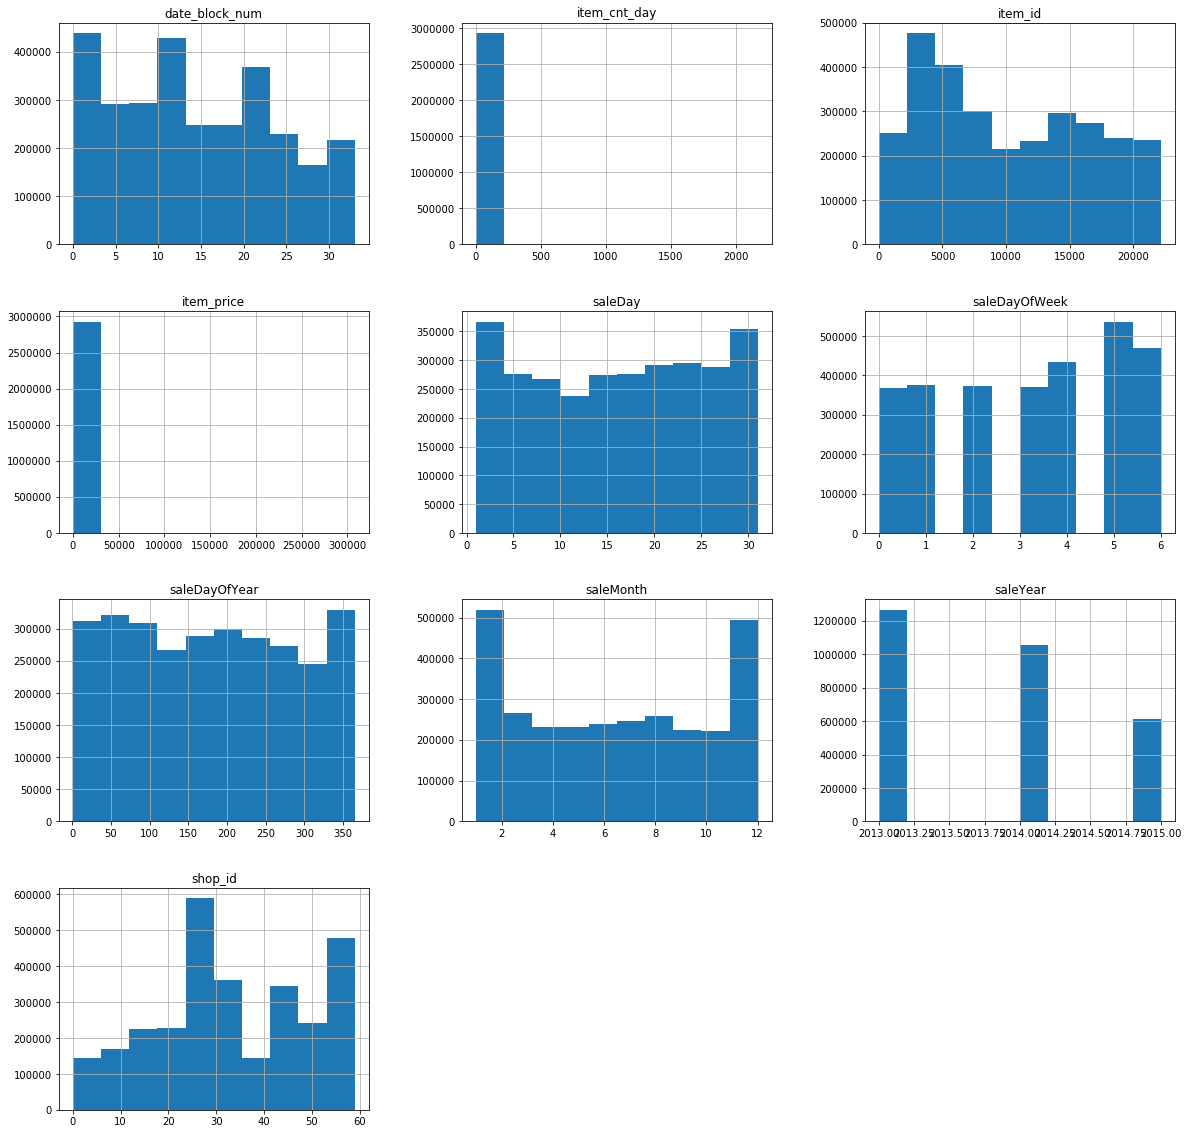

In [61]:
df_tmp.hist(figsize=(20, 20));

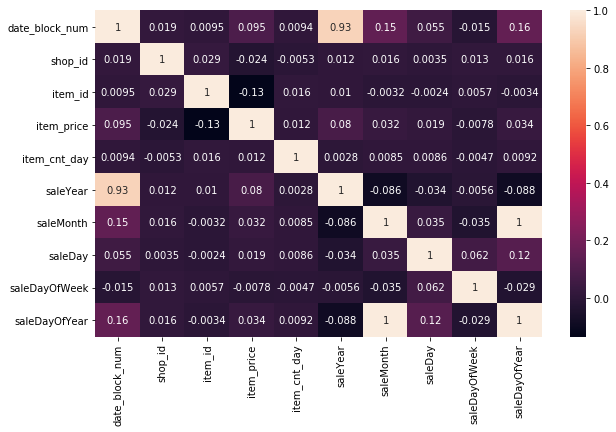

In [62]:
plt, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(df_tmp.corr(),
                annot=True,
                cbar=True);

In [63]:
#pair_plot = sns.pairplot(df_tmp, hue='item_cnt_day', palette='husl')

In [64]:
sales_by_item_id

,item_id,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21802,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
21803,0,0,0,0,0,0,0,0,0,23,...,7,8,12,4,8,10,8,11,5,11
21804,0,0,0,0,0,0,0,0,56,146,...,33,46,40,38,31,33,34,29,21,37
21805,2,2,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


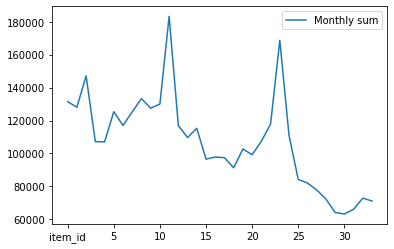

In [65]:
sales_by_item_id.sum().plot(legend=True, label='Monthly sum');

In [66]:
df_tmp.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
54411,0,8,22069,149.000000,1,2013,1,1,1,1
114730,0,46,5272,599.000000,2,2013,1,1,1,1
76820,0,54,19732,149.000000,1,2013,1,1,1,1
92283,0,42,11249,398.459991,2,2013,1,1,1,1
110440,0,46,8070,199.000000,1,2013,1,1,1,1


Sale volume outliers: [ 9242  8057 20949 19437  3731 11373  9248  9249]


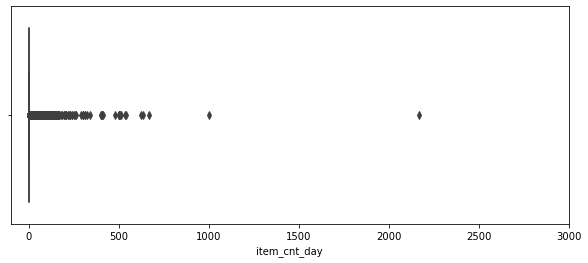

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4)) 
plt.xlim(-100, 3000)
sns.boxplot(x=df_tmp['item_cnt_day'])
print("Sale volume outliers:", df_tmp['item_id'][df_tmp['item_cnt_day']>500].unique())

Item price outliers: [11365  6066 13199]


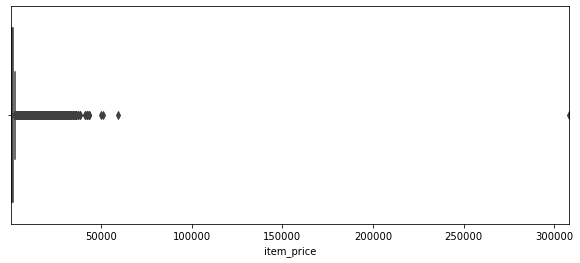

In [68]:
plt.figure(figsize=(10, 4))
plt.xlim(df_tmp['item_price'].min(), df_tmp['item_price'].max())
sns.boxplot(x=df_tmp['item_price'])
print('Item price outliers:', df_tmp['item_id'][df_tmp['item_price']>50000].unique())

In [69]:
df_tmp[df_tmp['item_price'] == 307980.0]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
1163158,11,12,6066,307980.0,1,2013,12,13,4,347


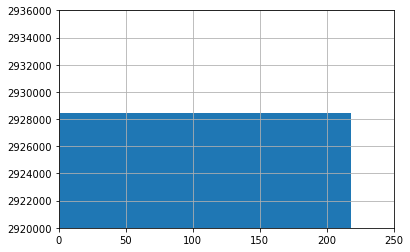

In [70]:
plt.xlim(0, 250)
plt.ylim(2920000, 2936000)
x = df_tmp['item_cnt_day']
x.hist();

## Let's load test.csv

In [71]:
df_tmp.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
54411,0,8,22069,149.000000,1,2013,1,1,1,1
114730,0,46,5272,599.000000,2,2013,1,1,1,1
76820,0,54,19732,149.000000,1,2013,1,1,1,1
92283,0,42,11249,398.459991,2,2013,1,1,1,1
110440,0,46,8070,199.000000,1,2013,1,1,1,1


In [72]:
df_tmp[(df_tmp['item_id'] == 5037) & (df_tmp['shop_id'] == 5)]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
1953995,20,5,5037,2599.0,1,2014,9,21,6,264
2150561,22,5,5037,2599.0,1,2014,11,29,5,333
2288631,23,5,5037,1999.0,1,2014,12,20,5,354
2288630,23,5,5037,1999.0,1,2014,12,28,6,362
2335446,24,5,5037,1999.0,1,2015,2,1,6,32
2719247,30,5,5037,1499.0,1,2015,5,7,3,127
2860998,32,5,5037,749.5,1,2015,5,9,5,129
2618926,28,5,5037,1299.0,1,2015,5,29,4,149
2704068,29,5,5037,1499.0,1,2015,6,28,6,179
2335447,24,5,5037,1999.0,1,2015,7,1,2,182


In [73]:
test_df

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757


In [74]:
len(test_df[test_df['shop_id'] == 5])

5100

In [75]:
# Outdated items in the last 6 months in test_df
print("Outdated items in test set:", len(test_df[test_df['item_id'].isin(outdated_items['item_id'])]))

Outdated items in test set: 1260


Are those outliers? Should they be deleted?

In [76]:
len(test_df), len(df_tmp)

(214200, 2928486)

In [77]:
test_df['shop_id'].value_counts()

59    5100
16    5100
28    5100
26    5100
25    5100
24    5100
22    5100
21    5100
19    5100
18    5100
15    5100
58    5100
14    5100
12    5100
10    5100
7     5100
6     5100
5     5100
4     5100
3     5100
31    5100
34    5100
35    5100
36    5100
57    5100
56    5100
55    5100
53    5100
52    5100
50    5100
49    5100
48    5100
47    5100
46    5100
45    5100
44    5100
42    5100
41    5100
39    5100
38    5100
37    5100
2     5100
Name: shop_id, dtype: int64

In [78]:
# How many items haven't sold for 6 months straight in the test_df?


In [79]:
df_tmp[df_tmp['date_block_num'] == 33]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
2891542,33,31,15450,999.0,1,2015,1,10,5,10
2928958,33,24,1384,198.0,2,2015,1,10,5,10
2931550,33,21,10298,169.0,2,2015,1,10,5,10
2886120,33,42,11655,1999.0,10,2015,1,10,5,10
2918501,33,9,20602,1549.0,4,2015,1,10,5,10
...,...,...,...,...,...,...,...,...,...,...
2917779,33,3,16208,399.0,1,2015,12,10,3,344
2924205,33,25,19602,169.0,1,2015,12,10,3,344
2890914,33,31,12974,249.0,1,2015,12,10,3,344
2891057,33,31,17375,399.0,1,2015,12,10,3,344


## Trying David's solution


In [80]:
#initalize df
df_helper = {}

df_helper['date_block_num'] = [34]*31
df_helper['shop_id'] = [-1]*31
df_helper['item_id'] = [-1]*31
df_helper['item_price'] = [-1]*31


# Dates
df_helper['saleYear'] = [2015]*31
df_helper['saleMonth'] = [11]*31
df_helper['saleDay'] = [x for x in range(1, 32)]
df_helper['saleDayOfWeek'] = [(x+5) % 7 for x in range(1, 32)] # Nov 1 was Sunday (val ==6)
df_helper['saleDayOfYear'] = [(x+304)  for x in range(1, 32)] # Nov 1 was 305th day of year


df_helper = pd.DataFrame(df_helper)
df_helper

,date_block_num,shop_id,item_id,item_price,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,34,-1,-1,-1,2015,11,1,6,305
1,34,-1,-1,-1,2015,11,2,0,306
2,34,-1,-1,-1,2015,11,3,1,307
3,34,-1,-1,-1,2015,11,4,2,308
4,34,-1,-1,-1,2015,11,5,3,309
5,34,-1,-1,-1,2015,11,6,4,310
6,34,-1,-1,-1,2015,11,7,5,311
7,34,-1,-1,-1,2015,11,8,6,312
8,34,-1,-1,-1,2015,11,9,0,313
9,34,-1,-1,-1,2015,11,10,1,314


In [81]:
def getMonthlySales(shop_id, item_id):
    global df_helper
    
    df_helper['shop_id'] = [shop_id]*31
    df_helper['item_id'] = [item_id]*31

    y_preds = model.predict(df_helper)
    
    return sum(y_preds)

In [82]:
results = test_df[:10].apply(lambda x: getMonthlySales(x['shop_id'], x['item_id']), axis=1)

In [83]:
results

ID
0    116.07
1    116.07
2    116.07
3    116.07
4    116.07
5    116.07
6    116.07
7    116.07
8    116.07
9    116.07
dtype: float64

In [84]:
# Create new dataframe in order to see patterns in prices
df_5 = df_tmp[(df_tmp['item_id'] == 5037) & (df_tmp['shop_id'] == 5)]
df_5

,date_block_num,shop_id,item_id,item_price,item_cnt_day,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
1953995,20,5,5037,2599.0,1,2014,9,21,6,264
2150561,22,5,5037,2599.0,1,2014,11,29,5,333
2288631,23,5,5037,1999.0,1,2014,12,20,5,354
2288630,23,5,5037,1999.0,1,2014,12,28,6,362
2335446,24,5,5037,1999.0,1,2015,2,1,6,32
2719247,30,5,5037,1499.0,1,2015,5,7,3,127
2860998,32,5,5037,749.5,1,2015,5,9,5,129
2618926,28,5,5037,1299.0,1,2015,5,29,4,149
2704068,29,5,5037,1499.0,1,2015,6,28,6,179
2335447,24,5,5037,1999.0,1,2015,7,1,2,182


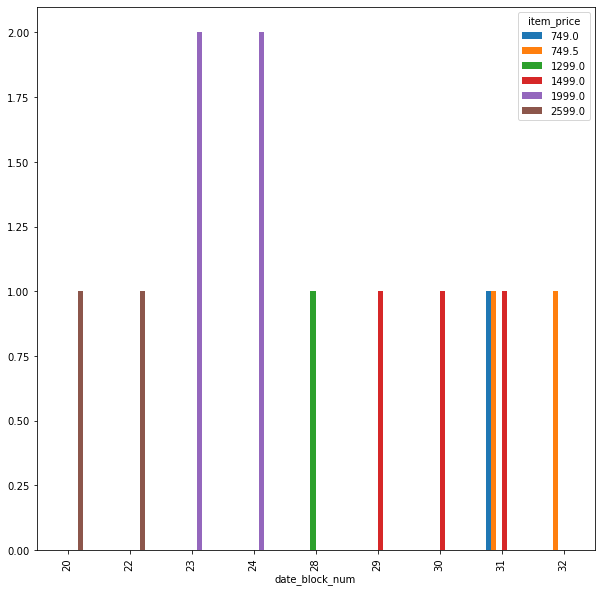

In [85]:
# Graph the patterns
pd.crosstab(df_5['date_block_num'], df_5['item_price']).plot(kind='bar',
                                                            figsize=(10, 10));

In [86]:
df_helper.head()

,date_block_num,shop_id,item_id,item_price,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,34,5,5003,-1,2015,11,1,6,305
1,34,5,5003,-1,2015,11,2,0,306
2,34,5,5003,-1,2015,11,3,1,307
3,34,5,5003,-1,2015,11,4,2,308
4,34,5,5003,-1,2015,11,5,3,309


In [87]:
test_df.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [88]:
len(df_helper), len(df_tmp), len(test_df)

(31, 2928486, 214200)

### Tony's method (please work 😺)

In [89]:
len(test_df['shop_id'].value_counts())

42

In [90]:
len(test_df['item_id'].value_counts())

5100

In [91]:
sum((test_df['item_id'] == 5037))

42

In [92]:
sum(test_df['item_id'] == 5320)

42

In [93]:
sum(test_df['item_id'] == 5268)

42

In [94]:
# This is very interesting. So what I have found is that
# There are 42 stores and they all have the same items.

In [125]:
df_tmp['revenue'] = df_tmp['item_price'] * df_tmp['item_cnt_day']
df_tmp.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,revenue
54411,0,8,22069,149.000000,1,2013,1,1,1,1,149.000000
114730,0,46,5272,599.000000,2,2013,1,1,1,1,1198.000000
76820,0,54,19732,149.000000,1,2013,1,1,1,1,149.000000
92283,0,42,11249,398.459991,2,2013,1,1,1,1,796.919983
110440,0,46,8070,199.000000,1,2013,1,1,1,1,199.000000


In [141]:
# Denis' implementation
group = df_tmp.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
group['item_cnt_month'].fillna(0, inplace=True)
group

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2
...,...,...,...,...
1608221,33,59,22087,6
1608222,33,59,22088,2
1608223,33,59,22091,1
1608224,33,59,22100,1


In [139]:
test_df['date_block_num'] = 34
test_df['date_block_num'] = test_df['date_block_num'].astype(np.int8)
test_df['shop_id'] = test_df['shop_id'].astype(np.int8)
test_df['item_id'] = test_df['item_id'].astype(np.int16)
test_df.head()

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [109]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = df_tmp[df_tmp.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [110]:
matrix

,date_block_num,shop_id,item_id
162199,0,0,19
158629,0,0,27
156968,0,0,28
160614,0,0,29
154271,0,0,32
...,...,...,...
10696300,33,59,22162
10696509,33,59,22163
10696012,33,59,22164
10698092,33,59,22166


In [118]:
sales.shop_id.unique()

array([31, 24, 21, 42,  9, 20, 16, 15, 22, 59, 57, 25, 46, 58, 56,  7, 47,
       35, 18, 14, 53, 49, 37,  6, 10, 50, 38, 26, 45, 52, 55, 48, 12, 39,
       44, 28,  5, 41, 19,  2,  3,  4, 34, 36], dtype=int16)

In [119]:
i=2
s = list(product([i], sales.shop_id.unique(), sales.item_id.unique()))

In [121]:
s[-10:]

[(2, 36, 4534),
 (2, 36, 14402),
 (2, 36, 5189),
 (2, 36, 10842),
 (2, 36, 20520),
 (2, 36, 10377),
 (2, 36, 18500),
 (2, 36, 21620),
 (2, 36, 14194),
 (2, 36, 17172)]

In [142]:
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2


In [144]:
test_df.head()

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [159]:
test = pd.DataFrame()
test['date_block_num'] = test_df['date_block_num']
test['shop_id'] = test_df['shop_id']
test['item_id'] = test_df['item_id']
test

,date_block_num,shop_id,item_id
ID,,,
0,34,5,5037
1,34,5,5320
2,34,5,5233
3,34,5,5232
4,34,5,5268
...,...,...,...
214195,34,45,18454
214196,34,45,16188
214197,34,45,15757


In [160]:
# Let's try to predict the monthly count for test_df
X_train = group[group.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = group[group.date_block_num < 33]['item_cnt_month']
X_valid = group[group.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = group[group.date_block_num == 33]['item_cnt_month']
X_test = test

In [161]:
%%time
model = XGBRegressor(
max_depth=8,
n_estimators=1000,
min_child_weight=300,
colsample_bytree=0.8,
subsample=0.8,
eta=0.3,
seed=42)

model.fit(X_train,
         y_train,
         eval_metric='rmse',
         eval_set=[(X_train, y_train), (X_valid, y_valid)],
         verbose=True,
         early_stopping_rounds=10)

[0]	validation_0-rmse:8.57195	validation_1-rmse:14.55884
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:8.51876	validation_1-rmse:14.53589
[2]	validation_0-rmse:8.49155	validation_1-rmse:14.53585
[3]	validation_0-rmse:8.47967	validation_1-rmse:14.52951
[4]	validation_0-rmse:7.94456	validation_1-rmse:14.25458
[5]	validation_0-rmse:7.93995	validation_1-rmse:14.25562
[6]	validation_0-rmse:7.93720	validation_1-rmse:14.26091
[7]	validation_0-rmse:7.53173	validation_1-rmse:14.06671
[8]	validation_0-rmse:7.53054	validation_1-rmse:14.05460
[9]	validation_0-rmse:7.35438	validation_1-rmse:13.97228
[10]	validation_0-rmse:7.35354	validation_1-rmse:13.98199
[11]	validation_0-rmse:7.25127	validation_1-rmse:13.96520
[12]	validation_0-rmse:7.25075	validation_1-rmse:13.96501
[13]	validation_0-rmse:7.14892	validation_1-rmse:13.91102
[14]	validation_0-rmse:7.09251	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [171]:
y_pred = model.predict(X_valid).clip(0, 20)

In [172]:
y_test = model.predict(X_test).clip(0, 20)

In [176]:
# Finally we have some kind of answer
submission = pd.DataFrame({
    "ID": test.index,
    "item_cnt_month": y_test
})
submission.to_csv("xgb_submission.csv", index=False)

# save predictions for an ensemble
pickle.dump(y_pred, open("xgb_train.pickle", 'wb'))
pickle.dump(y_test, open("xgb_test.pickle", 'wb'))